# Определение возраста покупателей

<b>Задача:</b>  
Постройте и обучите свёрточную нейронную сеть на датасете с фотографиями людей. Добейтесь значения MAE на тестовой выборке не больше 8.
Функцию загрузки тестовой выборки load_test(path) напишите самостоятельно. Вместе со старыми функциями в коде должны быть:
load_train(path),
load_test(path),
create_model(input_shape),
train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps).
В статье о датасете, с которым вы работаете, значение MAE равно 5.4 — если вы получите MAE меньше 7, это будет отличный результат!

## План

1. Исследовательский анализ данных.
2. Обучение модели.
3. Анализ обученнной модели.

## Исследовательский анализ данных

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Text(0, 0.5, 'Количество фотографий')

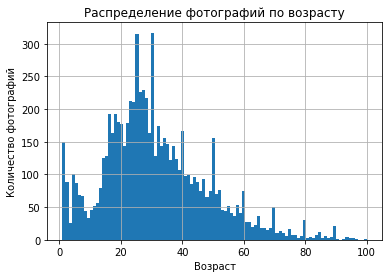

In [ ]:
labels.hist(bins=100)
plt.title('Распределение фотографий по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')

In [ ]:
labels.shape

(7591, 2)

In [ ]:
features, target = next(datagen_flow)

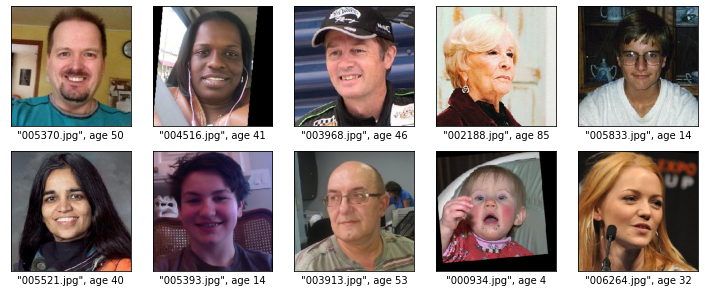

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.xlabel (f'"{datagen_flow.filenames[datagen_flow.index_array[i]]}", age {datagen_flow[0][1][i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Выводы:

- В датасете 7591 фотографий;

- Большая часть людей на фотографиях находятся в возрасте в диапазоне от 21 до 38 лет

- Некоторые фото не отцентрованы, бывают лишние предметы перед лицом

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow
    
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model
    
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

2023-05-05 12:20:35.144759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties:
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-05-05 12:20:35.321953: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-05-05 12:20:35.328255: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2023-05-05 12:20:35.328876: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3ef0000 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-05 12:20:35.328906: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-05-05 12:20:35.491379: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x52054b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-05 12:20:35.491427: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-05-05 12:20:35.493453: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties:
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

2023-05-05 12:20:35.497278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-05-05 12:20:35.497360: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-05-05 12:20:36.373514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-05-05 12:20:36.373577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0
2023-05-05 12:20:36.373589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N
2023-05-05 12:20:36.377529: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-05-05 12:20:36.377606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
  270336/94765736 [..............................] - ETA: 20s
 1875968/94765736 [..............................] - ETA: 5s 
 6914048/94765736 [=>............................] - ETA: 2s
15040512/94765736 [===>..........................] - ETA: 1s
22462464/94765736 [======>.......................] - ETA: 0s
29810688/94765736 [========>.....................] - ETA: 0s
37666816/94765736 [==========>...................] - ETA: 0s
45113344/94765736 [=============>................] - ETA: 0s
53231616/94765736 [===============>..............] - ETA: 0s
60563456/94765736 [==================>...........] - ETA: 0s
68370432/94765736 [====================>.........] - ETA: 0s
75538432/94765736 [======================>.......] - ETA: 0s
83001344/94765736 [=========================>....] - ETA: 0s
90783744/94765736 [===========================>..] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/5

356/356 - 88s - loss: 210.5466 - mae: 10.5514 - val_loss: 991.2014 - val_mae: 26.7829
Epoch 2/5
356/356 - 68s - loss: 83.8309 - mae: 6.9528 - val_loss: 155.0726 - val_mae: 9.3443
Epoch 3/5
356/356 - 67s - loss: 55.7709 - mae: 5.7126 - val_loss: 80.3479 - val_mae: 6.6486
Epoch 4/5
356/356 - 67s - loss: 42.2668 - mae: 4.9236 - val_loss: 72.8791 - val_mae: 6.4278
Epoch 5/5
356/356 - 58s - loss: 32.7828 - mae: 4.3915 - val_loss: 76.8403 - val_mae: 6.4826
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 76.8403 - mae: 6.4826
Test MAE: 6.4826

## Анализ обученной модели

- Я использовала модель сверточной нейронной сети на ResNet50;

- Модель показала минимальный MAE - 6.4278 на 4 эпохах;

- Модель обучается достаточно быстро, могу предположить, это потому что выборка не большая.